[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)

# 상태 스키마

## 상태 스키마

이 모듈에서는 상태를 저장하는 스키마와 이와 연관된 메모리에 대해서 좀 더 알아보겠습니다.

## 패키지 설치

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Bedrock Setting

In [1]:
import os
import getpass
import boto3
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
aws_region = os.getenv("AWS_REGION")
bedrock_client = boto3.client("bedrock-runtime", region_name=aws_region)

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

llm.invoke("what is the Amazon Nova?")

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


## 스키마

LangGraph에서 `StateGraph`를 정의할 때, 우리는 상태스키마를 사용합니다.

상태 스키마는 그래프가 사용하는 데이터를 저장하기 위한 데이터 구조와 데이터 타입을 말합니다.

그래프를 초기 선언할 때, 정의하면, 모든 노드들이 이 상태 스키마를 이용해서 커뮤니케이션합니다.

LangGraph에는 이 상태스키마를 정의해서 사용할 때, 유연한 구성 옵션들을 제공합니다. 그래서 다양한 Python 타입들을 수용하고, 다양한 접근 방법들을 제공합니다.

## TypedDict

상태스키마에서 기본적으로 사용하는 클래스 타입은 `TypedDict` 입니다.

이 클래스타입은, key를 명시하고, 그에 해당하는 값을 지정하는 것을 지원합니다.

하지만, 엄격하게 데이터타입을 규정해야 하는 업무에서는 `TypedDict` 기능 만으로는 부족합니다.

아래는 TypedDict의 예시입니다.

In [2]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

좀더 명확하게 데이터타입을 규정해서 해당 타입을 사용해야한다라고 하면, `Literal` 타입을 쓸 수 있습니다.

아래 예시에서 볼 수 있듯이, `mood`는 "happy"나 "sad"만 될 수 있습니다.

In [3]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

랭그래프에서 `StateGraph`를 입력하여, 우리는 사전정의된 상태 클래스를 사용할 수 있습니다.

그리고, 우리는 각 상태키는 전체 그래프의 커뮤니케이션에서 "채널" 역할로 수행하게 할 수 있습니다.

우리는 각 노드에서 상태그래프에 있는 상태키를 바꿀 수 있습니다.

## 그래프 생성

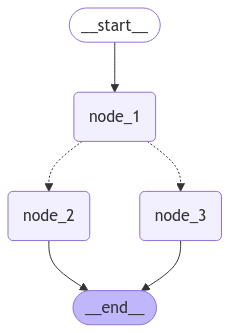

In [4]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

스테이트는 딕셔너리이므로 딕셔너리로 그래프를 호출하여 스테이트의 `name` 키의 초기 값을 설정하기만 하면 됩니다.

In [5]:
graph.invoke({"name":"Lance"})

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Dataclass

파이썬의 데이터클래스는 구조화된 데이터를 정의하는 또 다른 방법을 제공합니다.

데이터클래스는 주로 데이터를 저장하는 데 사용되는 클래스를 생성하기 위한 간결한 구문을 제공합니다.

In [6]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

데이터클래스의 키에 액세스하려면 node_1에서 사용된 상태스키마를 수정하기만 하면 됩니다:

데이터 클래스 상태에는 위의 TypedDict에 state[“name”]이 아닌 state.name을 사용합니다.

LangGraph가 상태 객체의 각 키를 개별적으로 저장합니다.

노드가 반환하는 객체에는 상태의 키(속성)와 일치하는 키만 있으면 됩니다!

이 경우 데이터클래스에 키 이름이 있으므로 state가 TypedDict일 때와 마찬가지로 노드에서 딕셔너리를 전달하여 업데이트할 수 있습니다.

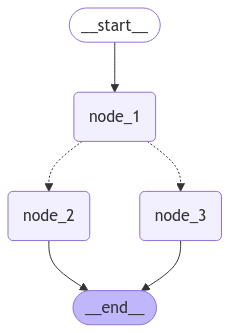

In [7]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

데이터클래스로 호출하여 스테이트의 각 키/채널의 초기값을 설정합니다!
아래와 같이 초기값을 설정하여 수행하도록 유도할 수 있습니다.

In [8]:
graph.invoke(DataclassState(name="Lance",mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## Pydantic

앞서 언급했듯이 TypedDict와 데이터클래스는 타입 힌트를 제공하지만 런타임에 타입을 강제하지는 않습니다.

즉, 오류를 발생시키지 않고 잘못된 값을 할당할 수 있습니다!

예를 들어, 유형 힌트에 무드가 지정되어 있어도 무드를 mad로 설정할 수 있습니다: `mood: list[Literal["happy","sad"]]`

In [9]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

Pydantic은 Python 유형 주석을 사용하는 데이터 유효성 검사 및 설정 관리 라이브러리입니다.

유효성 검사 기능으로 인해 LangGraph에서 상태 스키마를 정의하는 데 특히 적합합니다.

Pydantic은 유효성 검사를 수행하여 런타임에 데이터가 지정된 유형과 제약 조건을 준수하는지 확인할 수 있습니다.

In [10]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


이런 Pydantic의 기능을 이용해서 그래프에서 PydanticState를 원활하게 사용할 수 있습니다.

## 그래프 생성

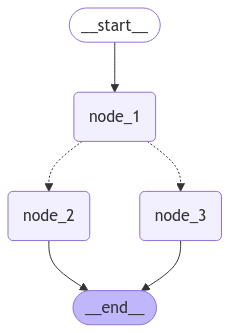

In [16]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}